In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties

Using TensorFlow backend.


In [2]:
Word_PATH="./Word_Data/Word/"
Vowel_PATH="./Vowel_Data/Vowel/"
seed=0

In [ ]:
def get_labels(path):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

def speech2mfcc(file_path,max_len):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    wave=wave[::2]
    mfcc=librosa.feature.mfcc(wave,sr=sr)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

def save_data_to_array(path, max_len):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)

def get_train_test(path,split_ratio=0.8,random_state=42):
    labels,indices,_=get_labels(path)

    X=np.load(labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True)


prop=FontProperties()
prop.set_file('/usr/share/fonts/Kalpurush.ttf')

def plot_cnf_mat(cm,classes,title,normalize=True): #Normalization can be avoided by setting normalize=False
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    plt.figure(figsize=(10,9))
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontproperties=prop,fontsize=24)
    plt.yticks(tick_marks,classes,fontproperties=prop,fontsize=24)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",fontsize=18)
    
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    plt.tight_layout()
    plt.savefig('./Result/Meet_the_Reviewer_Comments/'+title+'_1200dpi.svg',format='svg',dpi=1200)

Normalized confusion matrix
[[0.88 0.12 0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


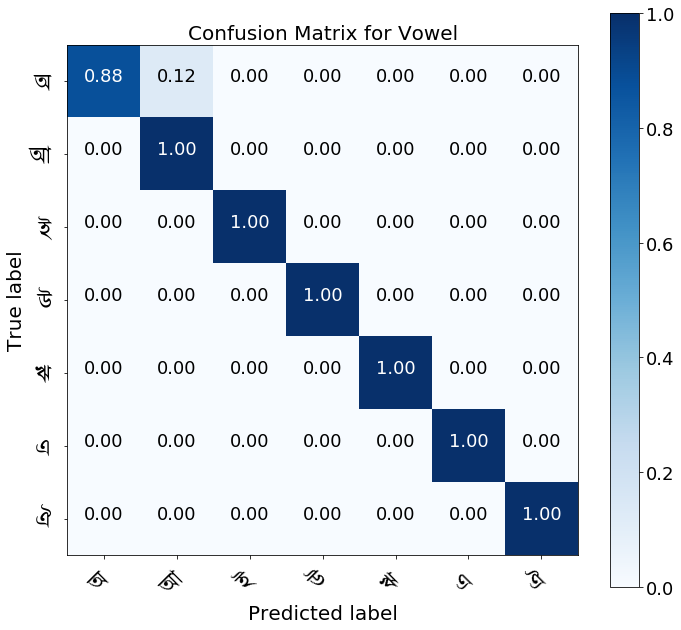

In [8]:
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Vowel')

Saving vectors to label -'vowel7': 100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Normalized confusion matrix
[[0.88 0.12 0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


<Figure size 432x288 with 0 Axes>

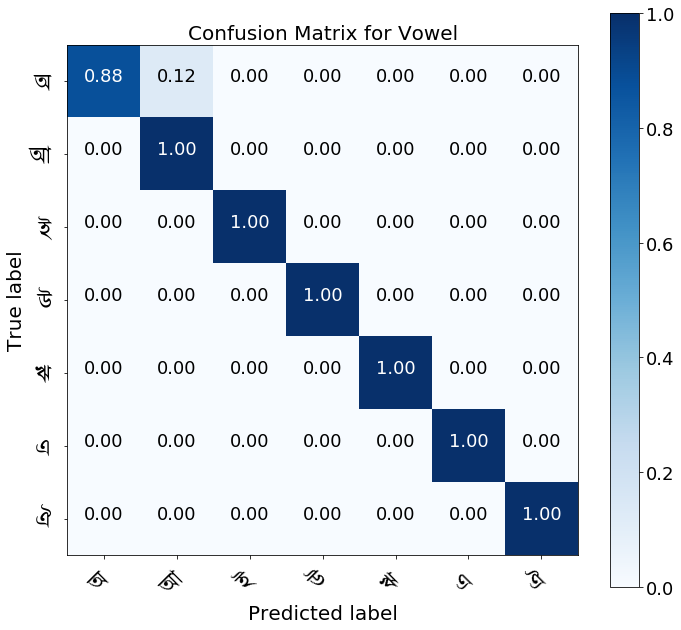

In [5]:
#Vowel

LEN_v=13

save_data_to_array(Vowel_PATH,LEN_v)

np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test(Vowel_PATH)
X_train=X_train.reshape(X_train.shape[0],20,LEN_v,1)
X_test=X_test.reshape(X_test.shape[0],20,LEN_v,1)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

model=Sequential()
model.add(Conv2D(64,kernel_size=(2,2),activation='tanh',input_shape=(20,LEN_v,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=0)
y_pred=model.predict_classes(X_test)


class_names=['অ ','আ ','ই ','উ ','ঋ ','এ ','ঐ ']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Vowel')
plt.show()

Saving vectors to label -'Word7': 100%|██████████| 40/40 [00:04<00:00,  8.84it/s]


Normalized confusion matrix
[[0.88 0.12 0.   0.   0.   0.   0.  ]
 [0.18 0.73 0.   0.09 0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.22 0.   0.   0.78 0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.09 0.91 0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


<Figure size 432x288 with 0 Axes>

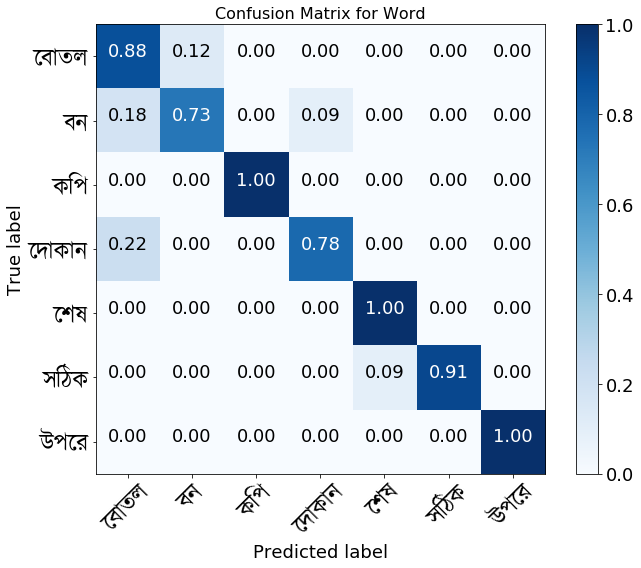

In [49]:
#Word

LEN_w=13
save_data_to_array(Word_PATH,LEN_w)

np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test(Word_PATH)
X_train=X_train.reshape(X_train.shape[0],20,LEN_w,1)
X_test=X_test.reshape(X_test.shape[0],20,LEN_w,1)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

model=Sequential()
model.add(Conv2D(64,kernel_size=(2,2),activation='tanh',input_shape=(20,LEN_w,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=0)
y_pred=model.predict_classes(X_test)

class_names=['েবাতল','বন','কিপ','েদাকান','েশষ','সিঠক','উপের']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Word')
plt.show()